In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
# temporary path until we do real archiving
path = Path('../data/raw/ACP_data_062424.csv')
assert path.exists()
acp = pd.read_csv(path)
acp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9069 entries, 0 to 9068
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ProjectName                    9069 non-null   object 
 1   PhaseName                      9069 non-null   object 
 2   MW_Total_Capacity              9069 non-null   float64
 3   Units_Total                    9069 non-null   int64  
 4   MW_Online_Capacity             7579 non-null   float64
 5   Units_Online                   7579 non-null   float64
 6   MW_UnderConstruction_Capacity  546 non-null    float64
 7   Units_UnderConstruction        546 non-null    float64
 8   MW_AdvDevelopment_Capacity     818 non-null    float64
 9   Units_AdvDevelopment           818 non-null    float64
 10  MW_Decommissioned_Capacity     164 non-null    float64
 11  Units_Decommissioned           164 non-null    float64
 12  Status                         9067 non-null   o

In [5]:
acp.head().T

,0,1,2,3,4
ProjectName,Ortega Battery Storage,Bancroft Station (Silicon Ranch Arlington II),Borough of Chambersburg Solar Center,SunEast Friendship Solar Project,SunEast Friendship Solar Project
PhaseName,Ortega Battery Storage,Bancroft Station (Silicon Ranch Arlington II),Borough of Chambersburg Solar Center,Friendship I,Friendship II
MW_Total_Capacity,20.0,102.5,15.0,2.0,2.0
Units_Total,0,355000,0,0,0
MW_Online_Capacity,NaN,102.5,15.0,2.0,2.0
Units_Online,NaN,355000.0,0.0,0.0,0.0
MW_UnderConstruction_Capacity,20.0,NaN,NaN,NaN,NaN
Units_UnderConstruction,0.0,NaN,NaN,NaN,NaN
MW_AdvDevelopment_Capacity,NaN,NaN,NaN,NaN,NaN
Units_AdvDevelopment,NaN,NaN,NaN,NaN,NaN


# QA

**Subsetting the rows**

DBCP is primarily interested in proposed projects, so I'll pay special attention to rows with `Status` in `('Advanced Development', 'Under Construction')`.

**Subsetting the columns**

DBCP asked for a subset of columns:
* EIAPlantCode
* Project name
* Phase name
* MW_Total_Capacity
* State
* Counties
* ISORTOs
* Developers
* Owners
* OwnerType
* AvgLatitude
* AvgLongitude

Plus add two derived columns:
* a surrogate key
* county FIPS code

I think we also need to add:
* `Status`
* `PhaseType`

In [4]:
row_subset = acp['Status'].isin({'Under Construction', 'Advanced Development'})
col_subset = [
    'Status',
    'EIAPlantCode',
    'ProjectName',
    'PhaseName',
    'PhaseType',
    'MW_Total_Capacity',
    'States',
    'Counties',
    'ISORTOs',
    'Developers',
    'Owners',
    'OwnerTypes',
    'AvgLatitude',
    'AvgLongitude',
]
row_subset.mean(), row_subset.sum()

(0.15029220421215128, 1363)

## Completeness

Missing values look reasonable. The critical columns have good coverage. `Developers` is the only column with a lot of unexpected missing values. `ISORTOs` is also missing a lot of values, but that is expected because many projects are in non-ISO territories.

In [5]:
# overall missingness
acp[col_subset].isna().agg(['sum', 'mean']).T.sort_values('mean', ascending=False)

,sum,mean
Developers,4385.0,0.483515
ISORTOs,3256.0,0.359025
EIAPlantCode,1207.0,0.133091
AvgLatitude,425.0,0.046863
AvgLongitude,425.0,0.046863
Owners,240.0,0.026464
OwnerTypes,238.0,0.026243
Counties,14.0,0.001544
Status,2.0,0.000221
ProjectName,0.0,0.000000


In [6]:
# account for '' vs NaN null representation. Only Counties change
acp[col_subset].select_dtypes('object').apply(lambda s: s.str.strip(), axis=1).fillna('').eq('').agg(['sum', 'mean']).T.sort_values('mean', ascending=False)

,sum,mean
Developers,4385.0,0.483515
ISORTOs,3256.0,0.359025
Owners,240.0,0.026464
OwnerTypes,238.0,0.026243
Counties,63.0,0.006947
Status,2.0,0.000221
ProjectName,0.0,0.000000
PhaseName,0.0,0.000000
PhaseType,0.0,0.000000
States,0.0,0.000000


In [7]:
# missingness in the proposed projects only
acp.loc[row_subset, col_subset].isna().agg(['sum', 'mean']).T.sort_values('mean', ascending=False)

,sum,mean
ISORTOs,938.0,0.688188
EIAPlantCode,762.0,0.559061
AvgLatitude,323.0,0.236977
AvgLongitude,323.0,0.236977
Developers,101.0,0.074101
Owners,42.0,0.030814
OwnerTypes,42.0,0.030814
Counties,4.0,0.002935
Status,0.0,0.000000
ProjectName,0.0,0.000000


In [8]:
# missingness by Status
acp['Developers'].isna().groupby(acp['Status']).agg(['sum', 'mean'])

,sum,mean
Status,,
Advanced Development,55,0.067319
Decommissioned,35,0.277778
Online,4245,0.562997
Online | Decommissioned,4,0.105263
Under Construction,46,0.084249


## Validity

### Range Validation

EIAPlantCode and MW_Total_Capacity look fine. There are some outlier lat/lon values, as always. It might be worth checking that the lat/lon values are within the claimed state.

In [9]:
numeric_cols = ['EIAPlantCode', 'MW_Total_Capacity', 'AvgLatitude', 'AvgLongitude']

In [10]:
acp.loc[:, numeric_cols].describe()

,EIAPlantCode,MW_Total_Capacity,AvgLatitude,AvgLongitude
count,7862.000000,9069.000000,8644.000000,8644.000000
mean,60833.299924,48.724354,38.337667,-92.938280
std,7181.371339,109.598027,5.426813,18.219918
min,90.000000,0.000000,-88.401600,-171.711610
25%,59097.250000,2.000000,34.829892,-105.030477
50%,61641.000000,5.000000,38.908632,-89.976107
75%,64023.750000,60.000000,42.245620,-77.799880
max,67538.000000,3515.000000,66.893610,144.722686


In [11]:
acp.loc[row_subset, numeric_cols].describe()

,EIAPlantCode,MW_Total_Capacity,AvgLatitude,AvgLongitude
count,601.000000,1363.000000,1040.000000,1040.000000
mean,65250.866889,122.112625,36.766705,-93.293580
std,4053.719471,212.718359,6.395204,18.566122
min,4162.000000,0.150000,-88.401600,-158.176700
25%,64658.000000,11.440000,33.739005,-106.999792
50%,65997.000000,74.900000,36.871282,-87.789225
75%,66900.000000,150.500000,40.812663,-78.967122
max,67538.000000,3515.000000,61.165817,35.642700


In [12]:
# assume 0 MW capacity is actually missing. What does it look like?
# [it turns out decommisioned projects are sometimes listed as 0 MW_total_capacity
# with non-zero MW_decommissioned_capacity]
acp.loc[acp['MW_Total_Capacity'] == 0, :].sample(5, random_state=0)

,ProjectName,PhaseName,MW_Total_Capacity,Units_Total,MW_Online_Capacity,Units_Online,MW_UnderConstruction_Capacity,Units_UnderConstruction,MW_AdvDevelopment_Capacity,Units_AdvDevelopment,...,CongressionalDistricts,EIAPlantCode,SecondaryOfftakeTypes,SecondaryPurchaserIDs,SecondaryPurchaserTypes,TrackingTypes,ILRs,NameplateMWs,StorageEnergies,StorageDurations
2891,Foote Creek I,Foote Creek I,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,WY-00,55607.0,NaN,NaN,NaN,NaN,NaN,0.6,NaN,NaN
2279,DifWind Farms Ltd. I,DifWind Farms Ltd. I,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,CA-41,54681.0,NaN,NaN,NaN,NaN,NaN,0.108,NaN,NaN
6222,Pinnacle Wind Force,Pinnacle,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,WV-02,57595.0,NaN,NaN,NaN,NaN,NaN,2.4,NaN,NaN
4151,Jake Energy Storage Center,Jake Energy Storage Center,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,IL-14,59960.0,NaN,NaN,NaN,NaN,NaN,0,7.9,0.39899
278,Altamont Wind Farm,Altamont Wind Farm,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,CA-14,50712.0,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN


In [13]:
# are they all decommissioned?
acp.loc[acp['MW_Total_Capacity'] == 0, "Status"].value_counts(dropna=False)

Decommissioned    126
NaN                 2
Name: Status, dtype: int64

In [14]:
# is the reverse true? [yes. Investigate further in cross-field validation]
acp.loc[acp['Status'].eq('Decommissioned'), 'MW_Total_Capacity'].value_counts(dropna=False)

0.0    126
Name: MW_Total_Capacity, dtype: int64

In [15]:
from itertools import chain
pd.Index(chain(acp['AvgLongitude'].nlargest(5).index, acp['AvgLongitude'].nsmallest(5).index))

Int64Index([3476, 5454, 605, 7250, 6422, 3115, 7012, 6906, 8502, 8031], dtype='int64')

In [16]:
# the one in TN has the lat/lon swapped
# the ones in AZ and CA are in the caribbean sea for some reason. I don't see a simple fix for those.
extrema_idx = pd.Index(
    chain(
        acp['AvgLongitude'].nlargest(5).index,
        acp['AvgLongitude'].nsmallest(5).index,
        acp['AvgLatitude'].nlargest(5).index,
        acp['AvgLatitude'].nsmallest(5).index,
    )
).drop_duplicates()
acp.loc[extrema_idx, col_subset]

,Status,EIAPlantCode,ProjectName,PhaseName,PhaseType,MW_Total_Capacity,States,Counties,ISORTOs,Developers,Owners,OwnerTypes,AvgLatitude,AvgLongitude
3476,Online,NaN,Guam Power Authority Wind Turbine,Guam Power Authority Wind Turbine,Wind,0.275,GU,Guam,NaN,Guam Power Authority,Guam Power Authority,Utility: Municipal,13.389242,144.722686
5454,Advanced Development,NaN,Natchez Trace,Natchez Trace Storage,Storage,200.000,TN,Henderson County,NaN,Origis Energy,Origis Energy,IPP,-88.401600,35.642700
605,Under Construction,66110.0,Babbitt Ranch,Babbitt Ranch Wind,Wind,162.960,AZ,| Coconino County,NaN,NextEra Energy Resources,NextEra Energy Resources,IPP,17.815337,-55.960513
7250,Online,63735.0,Silverstrand Battery Storage,Silverstrand Battery Storage Project,Storage,11.000,CA,Ventura County,CAISO,"Able Grid Energy Solutions, Inc.","Able Grid Energy Solutions, Inc.",IPP,17.103930,-59.539875
6422,Online,61132.0,Punta Lima,Punta Lima,Wind,23.400,PR,Naguabo Municipio,NaN,Elawan Wind,"Santander Bank, N. A.",IPP,18.194965,-65.697051
3115,Online,NaN,Gambell Wind,Gambell Wind,Wind,0.300,AK,Nome Census Area,NaN,Alaska Village Electric Cooperative,Alaska Village Electric Cooperative,Utility: Cooperative,63.778809,-171.711610
7012,Online,57052.0,Savoonga,Savoonga,Wind,0.200,AK,Nome Census Area,NaN,Alaska Village Electric Cooperative,Alaska Village Electric Cooperative,Utility: Cooperative,63.691851,-170.498106
6906,Online,NaN,Saint Paul Island,Saint Paul Island,Wind,0.225,AK,Aleutians West Census Area,NaN,Northern Power Systems,Tanadgusix Corporation,IPP,57.157489,-170.236297
8502,Online,NaN,Wales Wind Energy Project,Wales Wind Energy Project,Wind,0.100,AK,Nome Census Area,NaN,Kotzebue Electric Association,Kotzebue Electric Association,Utility: Cooperative,65.615797,-168.087278
8031,Online,NaN,Tin City Long Range Radar Station,Tin City Long Range Radar Station,Wind,0.225,AK,Nome Census Area,NaN,Tanadgusix Corporation,Tin City Long Range Radar Station,Government: Military,65.567224,-167.963857


### Uniqueness

No whole-row duplicates. But no single column is unique. (Status, PhaseName) is unique today but may not be tomorrow. Instead, I have to guess at what will remain unique in the future. (Status, PhaseName, PhaseType, MW_Total_Capacity, States, Counties, Owners)pretty much fully specifies a project, so I'll use that. Note that it won't be stable between updates, however, because projects can change owners, statuses, etc. But stability over time is a much harder problem and is out of scope for now.

In [17]:
# whole row duplicates?
acp.duplicated().sum()

0

In [18]:
# no unique iD
acp.nunique().eq(acp.shape[0]).any()

False

In [19]:
# PhaseName is very close to unique, but there will always be collisions by chance
acp.nunique().div(acp.shape[0]).nlargest(5)

PhaseName       0.999449
ProjectName     0.898556
AvgLongitude    0.889403
AvgLatitude     0.887749
EIAPlantCode    0.804609
dtype: float64

In [20]:
acp.loc[acp.duplicated(subset=['PhaseName'], keep=False), col_subset].sort_values(['PhaseName', 'States'])

,Status,EIAPlantCode,ProjectName,PhaseName,PhaseType,MW_Total_Capacity,States,Counties,ISORTOs,Developers,Owners,OwnerTypes,AvgLatitude,AvgLongitude
590,Advanced Development,66890.0,Azalea Solar + Storage,Azalea Solar,Solar,60.0,CA,Kern County,NaN,Idemitsu Renewables,Idemitsu Renewables,IPP,35.766735,-119.889915
589,Online,58482.0,Azalea Solar,Azalea Solar,Solar,7.7,GA,Washington County,NaN,NaN,Onward Energy,IPP,32.980833,-82.591670
714,Advanced Development,NaN,Beacon Solar,Beacon Solar,Solar,4.0,MA,Hampshire County,ISO-NE,HPS Investment Partners,Cypress Creek Renewables,IPP,42.285640,-72.681150
715,Online,66181.0,Beacon Solar + Storage,Beacon Solar,Solar,5.0,MA,Hampshire County,ISO-NE,NaN,Cypress Creek Renewables,IPP,42.284000,-72.677000
723,Online,58508.0,Bear Creek Solar (CA),Bear Creek Solar (CA),Solar,1.5,CA,San Joaquin County,CAISO,NaN,ALLCO Renewable Energy Limited | Ecos Energy LLC,IPP,38.136389,-121.148900
724,Under Construction,67169.0,"Bear Creek Solar (CA, Contra Costa County)",Bear Creek Solar (CA),Solar,5.0,CA,Contra Costa County,NaN,NaN,TotalEnergies,IPP,37.919197,-122.186300
4633,Advanced Development,NaN,Libra Solar Project,Libra Storage,Storage,700.0,NV,Mineral County,NaN,Arevia Power,Arevia Power,IPP,NaN,NaN
4634,Online,NaN,Libra Storage,Libra Storage,Storage,200.0,TX,Guadalupe County,NaN,ENGIE North America,ENGIE North America,IPP,29.472740,-97.981540
7001,Advanced Development,NaN,Sapphire Solar + Storage,Sapphire Solar,Solar,117.0,CA,Madera County,NaN,EDF Renewables,EDF Renewables,IPP,37.148573,-119.540651
7000,Online,61948.0,Sapphire Solar,Sapphire Solar,Solar,2.0,SC,Florence County,NaN,NaN,Southern Current,IPP,33.887786,-79.783680


In [21]:
# (Status, PhaseName) is unique but may not be future-proof
# Instead, I have to guess at what will remain unique in the future.
# (Status, PhaseName, PhaseType, MW_Total_Capacity, States, Counties, Owners) pretty much fully specifies a project
pk_cols = ['Status', 'PhaseName', 'PhaseType', 'MW_Total_Capacity', 'States', 'Counties', 'Owners']
acp.duplicated(subset=pk_cols).sum()

0

In [22]:
# could hash the primary key and use that as a surrogate key. But that should happen after cleaning.
# or just use a simple incrementing integer

# the built-in hash() is not deterministic across runs or machines (for security reasons)
import hashlib

def md5hash(s: str):
    return hashlib.md5(s.encode('utf-8')).hexdigest()

acp.loc[:, pk_cols].astype(str).sum(axis=1).apply(md5hash).duplicated().sum()

0

### Set Membership

There are some multi-valued columns:

* `Status` has `"Online | Decommissioned"` which is not sigificantly different from `"Online"`. I'll treat them as the same.
* Owner types can be multivalued, but only 1.4% overall and 0.15% of proposed projects. I'll just use the first one.
* Need to standardize the ISO names
* States and counties have minor multi-valuedness. I'll just use the first one. Great coverage otherwise.

In [23]:
cat_cols = ['Status', 'PhaseType', 'States', 'Counties', 'OwnerTypes', 'ISORTOs']
acp.loc[:, cat_cols].nunique()

Status           5
PhaseType        4
States          60
Counties      1357
OwnerTypes      33
ISORTOs         18
dtype: int64

In [24]:
# simple string cleaning has very little effect
pd.concat((
    acp[c].str.strip().str.lower() for c in cat_cols
), axis=1).nunique()

Status           5
PhaseType        4
States          60
Counties      1350
OwnerTypes      33
ISORTOs         18
dtype: int64

#### Status

In [25]:
# multivalued entries :(
acp.loc[:, cat_cols[0]].value_counts(dropna=False)

Online                     7540
Advanced Development        817
Under Construction          546
Decommissioned              126
Online | Decommissioned      38
NaN                           2
Name: Status, dtype: int64

In [26]:
# based on these examples, "Online/Decommissioned" simply means it is an Online project that has some decommissioned units. I will treat it as Online.
acp.loc[acp['Status'].str.contains('|', regex=False).fillna(False),:].sort_values(pk_cols).head(10)

,ProjectName,PhaseName,MW_Total_Capacity,Units_Total,MW_Online_Capacity,Units_Online,MW_UnderConstruction_Capacity,Units_UnderConstruction,MW_AdvDevelopment_Capacity,Units_AdvDevelopment,...,CongressionalDistricts,EIAPlantCode,SecondaryOfftakeTypes,SecondaryPurchaserIDs,SecondaryPurchaserTypes,TrackingTypes,ILRs,NameplateMWs,StorageEnergies,StorageDurations
1275,Cabazon Wind,Cabazon Wind,39.000,52,39.000,52.0,NaN,NaN,NaN,NaN,...,CA-25 | CA-41,50552.0,NaN,NaN,NaN,NaN,NaN,0.75,NaN,NaN
1812,Colorado Green Wind Project,Colorado Green Wind Project,162.000,100,162.000,100.0,NaN,NaN,NaN,NaN,...,CO-04,56173.0,NaN,NaN,NaN,NaN,NaN,1.5 | 1.62,NaN,NaN
1889,Coram,Coram Tehachapi,6.525,29,6.525,29.0,NaN,NaN,NaN,NaN,...,CA-20,54750.0,NaN,NaN,NaN,NaN,NaN,0.225,NaN,NaN
2004,Crescent Ridge,Crescent Ridge,61.000,28,61.000,28.0,NaN,NaN,NaN,NaN,...,IL-16,56297.0,NaN,NaN,NaN,NaN,NaN,1.65 | 2 | 2.2,NaN,NaN
2206,Desert Sky,Desert Sky,129.000,86,129.000,86.0,NaN,NaN,NaN,NaN,...,TX-23,55992.0,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN
2257,Diablo Wind,Diablo Wind,19.800,30,19.800,30.0,NaN,NaN,NaN,NaN,...,CA-14,56271.0,NaN,NaN,NaN,NaN,NaN,0.66,NaN,NaN
2480,EDF Renewable V,EDF Renewable V,6.500,65,6.500,65.0,NaN,NaN,NaN,NaN,...,CA-04,54453.0,NaN,NaN,NaN,NaN,NaN,0.1,NaN,NaN
2687,Ewington,Ewington,22.500,9,22.500,9.0,NaN,NaN,NaN,NaN,...,MN-01,56628.0,NaN,NaN,NaN,NaN,NaN,2.1 | 2.5,NaN,NaN
2855,Flat Ridge I,Flat Ridge I,38.000,19,38.000,19.0,NaN,NaN,NaN,NaN,...,KS-04,56879.0,NaN,NaN,NaN,NaN,NaN,2 | 2.5,NaN,NaN
3404,Green Power,Green Power,13.500,18,13.500,18.0,NaN,NaN,NaN,NaN,...,CA-25 | CA-41,55396.0,NaN,NaN,NaN,NaN,NaN,0.75,NaN,NaN


#### PhaseType

In [27]:
# needs string stripping but otherwise looks good
acp.loc[:, cat_cols[1]].value_counts(dropna=False)

Solar            6308
 Wind            1806
Storage           931
Offshore Wind      24
Name: PhaseType, dtype: int64

#### Owner Types

In [28]:
# multivalued
acp.loc[:, cat_cols[4]].value_counts(dropna=False)

 IPP                                                                          7023
 Utility: IOU                                                                 1022
NaN                                                                            238
 IPP: YieldCo                                                                  149
 Utility: Cooperative                                                          147
 Utility: Municipal                                                            140
 School                                                                         82
 IPP | Unknown                                                                  41
 Government: Local                                                              36
 Unknown                                                                        31
 Government: Federal                                                            26
 Government: State | Utility: IOU                                               24
 IPP

In [29]:
# drops from 33 types to 19
acp.loc[:, cat_cols[4]].str.split('|', regex=False).explode().str.strip().value_counts(dropna=False).sort_index()

C&I                                    8
Community                              1
Government: Federal                   26
Government: Local                     41
Government: Military                   8
Government: State                     33
IPP                                 7113
IPP: YieldCo                         170
Individual                            11
School                                83
Tribal                                 8
Unknown                               76
Utility: Cooperative                 155
Utility: Federal Power Authority       3
Utility: IOU                        1067
Utility: Municipal                   142
Utility: Political Subdivison         11
Utility: State                         2
NaN                                  238
Name: OwnerTypes, dtype: int64

In [30]:
# How many have multiple owner types?
acp.loc[:, cat_cols[4]].str.contains('|', regex=False).fillna(False).agg(['sum', 'mean'])

sum     125.000000
mean      0.013783
Name: OwnerTypes, dtype: float64

In [31]:
# How does this change within the proposed projects?
acp.loc[row_subset, cat_cols[4]].str.contains('|', regex=False).fillna(False).agg(['sum', 'mean'])

sum     2.000000
mean    0.001467
Name: OwnerTypes, dtype: float64

#### ISO RTOS

In [32]:
acp.loc[:, cat_cols[5]].value_counts(dropna=False)

NaN                                                3256
MISO                                               1305
PJM                                                1186
CAISO                                              1075
ISO-NE                                              907
ERCOT                                               492
NYISO                                               414
Southwest Power Pool                                258
SPP                                                 107
ISO New England                                      26
Southwest Power Pool | MISO                          12
PJM | MISO                                           12
WECC-RMRG                                             5
PJM Interconnection                                   4
NYISO | ISO-NE                                        3
NYISO | PJM                                           3
Southwest Power Pool | ERCOT                          2
Southwest Power Pool | PJM                      

In [33]:
# split multi-valued entries
# Need to standardize the names of the ISOs
acp.loc[:, cat_cols[5]].str.split('|', regex=False).explode().str.strip().value_counts(dropna=False).sort_index()

CAISO                                              1075
ERCOT                                               494
ISO New England                                      26
ISO-NE                                              910
MISO                                               1329
Midcontinent Independent System Operator (MISO)       1
NYISO                                               420
PJM                                                1202
PJM Interconnection                                   4
SPP                                                 107
Southwest Power Pool                                273
WECC-RMRG                                             5
NaN                                                3256
Name: ISORTOs, dtype: int64

In [34]:
# How many have multiple ISOs?
acp.loc[:, cat_cols[5]].str.contains('|', regex=False).fillna(False).agg(['sum', 'mean'])

sum     33.000000
mean     0.003639
Name: ISORTOs, dtype: float64

#### States

In [35]:
from dbcp.transform.helpers import add_county_fips_with_backup_geocoding

/app/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/app/.local/lib/python3.10/site-packages/pudl/analysis/spatial.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/

In [36]:
acp.loc[:, cat_cols[2]].value_counts(dropna=False)

 CA         1241
 NC          819
 TX          682
 MA          646
 MN          626
 NY          516
 NJ          311
 IL          250
 FL          237
 VA          226
 CO          225
 IA          199
 OR          193
 IN          182
 AZ          181
 NM          152
 MD          144
 SC          141
 MI          134
 GA          132
 OH          130
 ME          106
 WI          101
 PA           99
 KS           97
 OK           95
 NV           90
 RI           87
 HI           81
 VT           79
 CT           74
 UT           71
 NE           60
 ID           55
 ND           53
 MO           51
 TN           51
 WY           46
 MT           45
 WA           44
 AR           43
 SD           36
 MS           34
 AK           33
 KY           32
 LA           23
 AL           22
 WV           21
 PR           20
 DE           19
 NH           16
 DC           10
 NM | TX       1
 IA | MN       1
 OK | TX       1
 GU            1
 MN | SD       1
 CT | RI       1
 OR | WA      

In [37]:
multivalued_states = acp.loc[:, cat_cols[2]].str.contains('|', regex=False).fillna(False)
multivalued_states.aggregate(['sum', 'mean'])

sum     7.000000
mean    0.000772
Name: States, dtype: float64

In [38]:
# not many multi-state projects. But not ready to dismiss them until I see if multi-county projects are similarly rare.
acp.loc[multivalued_states, col_subset].sort_values(pk_cols)

,Status,EIAPlantCode,ProjectName,PhaseName,PhaseType,MW_Total_Capacity,States,Counties,ISORTOs,Developers,Owners,OwnerTypes,AvgLatitude,AvgLongitude
1135,Online,60145.0,Broadview Wind,Broadview Energy JN,Wind,181.70,NM | TX,Curry County | Deaf Smith County,CAISO,"Pattern Energy Group Services, LP | National R...","Pattern Energy Group, Inc. | Vertuous Energy",IPP,34.801037,-103.042118
3050,Online,64623.0,Freeborn Wind Energy,Freeborn Wind Energy,Wind,218.00,IA | MN,Freeborn County | Worth County,MISO,Xcel Energy,Northern States Power Company,Utility: IOU,43.499325,-93.128434
3381,Online,64667.0,Great Prairie Wind (Firewheel Wind),Great Prairie Wind 3,Wind,301.74,OK | TX,Hansford County | Sherman County | Texas County,SPP,NextEra Energy Resources,NextEra Energy Resources,IPP,36.455938,-101.495838
5209,Online,56459.0,MinnDakota Wind Farm,MinnDakota Wind Farm,Wind,150.00,MN | SD,Brookings County | Lincoln County,MISO,AVANGRID,AVANGRID,IPP,44.306669,-96.418790
7627,Online,55560.0,Stateline,Stateline,Wind,299.64,OR | WA,Umatilla County | Walla Walla County,NaN,NextEra Energy Resources,NextEra Energy Partners,IPP: YieldCo,46.004700,-118.805726
7932,Online,56669.0,Tatanka Wind,Tatanka,Wind,180.00,ND | SD,Dickey County | McPherson County,MISO,Acciona Energy USA Global LLC,Acciona Energy USA Global LLC | GE Capital | A...,IPP,45.936245,-98.984734
6642,Under Construction,65500.0,Revolution Wind,Revolution Wind,Offshore Wind,704.00,CT | RI,,ISO-NE,Orsted Wind Power North America LLC | Eversour...,Orsted Wind Power North America LLC | Eversour...,IPP | Utility: IOU,41.170670,-71.089250


#### Counties

On one hand, the ISO queue project tables already handle multi-county projects. On the other hand I'm supposed to merge this with 860m, and 860m has no multi-county projects. I think the fact that we are more interested in proposed projects and there is only a single multi-county proposed project means I can get away with just taking the first entry.

In [39]:
acp.loc[:, cat_cols[3]].str.contains('|', regex=False).fillna(False).agg(['sum', 'mean'])

sum     244.000000
mean      0.026905
Name: Counties, dtype: float64

In [40]:
acp.loc[row_subset, cat_cols[3]].str.contains('|', regex=False).fillna(False).agg(['sum', 'mean'])

sum     1.000000
mean    0.000734
Name: Counties, dtype: float64

In [41]:
def extract_first_array_value(s: pd.Series):
    return s.str.split('|', regex=False).str[0].str.strip()

locs = acp.loc[:, ['States', 'Counties']].apply(extract_first_array_value, axis=1)
locs = add_county_fips_with_backup_geocoding(locs, state_col='States', locality_col='Counties')

2024-07-21 22:46:25 [    INFO] catalystcoop.pudl.helpers:203 Assigned state FIPS codes for 100.00% of records.
2024-07-21 22:46:26 [    INFO] catalystcoop.pudl.helpers:219 Assigned county FIPS codes for 99.12% of records.
2024-07-21 22:46:26 [    INFO] catalystcoop.pudl.helpers:203 Assigned state FIPS codes for 100.00% of records.
2024-07-21 22:46:26 [    INFO] catalystcoop.pudl.helpers:219 Assigned county FIPS codes for 18.75% of records.


In [42]:
locs.info()  # county_id_fips coverage is really good! Over 99%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9069 entries, 0 to 9068
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   States                      9069 non-null   object
 1   Counties                    9055 non-null   object
 2   state_id_fips               9069 non-null   string
 3   county_id_fips              9004 non-null   string
 4   geocoded_locality_name      9069 non-null   object
 5   geocoded_locality_type      9069 non-null   object
 6   geocoded_containing_county  9005 non-null   string
dtypes: object(4), string(3)
memory usage: 496.1+ KB


In [43]:
# only 6 failures not caused by missing county names.
# The CT planning regions and Chugach AK should work. This might be a problem with the geocoder parsing.
# The other 3 are county names from neighboring states. They were multivalued entries where the counties were listed in a different order than the states. Not going to bother fixing that because there are so few.
locs.loc[locs['county_id_fips'].isna() & locs['Counties'].fillna('').ne(''), :].head(10)

,States,Counties,state_id_fips,county_id_fips,geocoded_locality_name,geocoded_locality_type,geocoded_containing_county
2709,AK,Chugach Census Area,02,<NA>,Chugach,county,Chugach
3050,IA,Freeborn County,19,<NA>,IA,,<NA>
3381,OK,Hansford County,40,<NA>,OK,,<NA>
4687,CT,Northwest Hills Planning Region,09,<NA>,CT,,<NA>
5209,MN,Brookings County,27,<NA>,MN,,<NA>
7603,CT,South Central Connecticut Planning Region,09,<NA>,CT,,<NA>


In [44]:
locs['county_id_fips'].isna().agg(['sum', 'mean'])

sum     65.000000
mean     0.007167
Name: county_id_fips, dtype: float64

### Type Validation

In [112]:
# check dtype of avg lat/lon
assert acp['AvgLatitude'].dtype == np.float64

In [45]:
# all look good. Just check that EIA IDs are actually ints with nulls
acp[col_subset].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9069 entries, 0 to 9068
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Status             9067 non-null   object 
 1   EIAPlantCode       7862 non-null   float64
 2   ProjectName        9069 non-null   object 
 3   PhaseName          9069 non-null   object 
 4   PhaseType          9069 non-null   object 
 5   MW_Total_Capacity  9069 non-null   float64
 6   States             9069 non-null   object 
 7   Counties           9055 non-null   object 
 8   ISORTOs            5813 non-null   object 
 9   Developers         4684 non-null   object 
 10  Owners             8829 non-null   object 
 11  OwnerTypes         8831 non-null   object 
 12  AvgLatitude        8644 non-null   float64
 13  AvgLongitude       8644 non-null   float64
dtypes: float64(4), object(10)
memory usage: 992.0+ KB


In [46]:
# check for non-integer EIA IDs
acp['EIAPlantCode'].mod(1).fillna(0).ne(0).sum()

0

### Cross-Field Validation

#### Lat/Lon vs State/County

In [49]:
from dbcp.extract.fips_tables import _extract_census_counties  # loads county shapefiles
import geopandas as gpd

census_uri = "gs://dgm-archive/census/tl_2021_us_county.zip"
shapes = _extract_census_counties(census_uri).set_geometry("geometry")
shapes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3234 entries, 0 to 3233
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   3234 non-null   object  
 1   COUNTYFP  3234 non-null   object  
 2   COUNTYNS  3234 non-null   object  
 3   GEOID     3234 non-null   object  
 4   NAME      3234 non-null   object  
 5   NAMELSAD  3234 non-null   object  
 6   LSAD      3234 non-null   object  
 7   CLASSFP   3234 non-null   object  
 8   MTFCC     3234 non-null   object  
 9   CSAFP     1256 non-null   object  
 10  CBSAFP    1916 non-null   object  
 11  METDIVFP  110 non-null    object  
 12  FUNCSTAT  3234 non-null   object  
 13  ALAND     3234 non-null   int64   
 14  AWATER    3234 non-null   int64   
 15  INTPTLAT  3234 non-null   object  
 16  INTPTLON  3234 non-null   object  
 17  geometry  3234 non-null   geometry
dtypes: geometry(1), int64(2), object(15)
memory usage: 454.9+ KB


In [50]:
shapes.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,NaN,NaN,NaN,A,1477645345,10690204,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,NaN,NaN,NaN,A,680976231,61568965,+46.2946377,-123.4244583,"POLYGON ((-123.49077 46.38358, -123.48813 46.3..."


In [51]:
points = gpd.GeoSeries.from_xy(
        acp["AvgLongitude"],
        acp["AvgLatitude"],
        index=acp.index,
        crs=shapes.crs,
    ).to_frame("lat_lon")

In [52]:
fips_lat_lon = points.sjoin(
    shapes.loc[:, ["GEOID", "geometry", "NAMELSAD"]],
    how="left",
    predicate="within",
)

In [64]:
fips_lat_lon.isna().agg(['sum', 'mean'])

,lat_lon,index_right,GEOID,NAMELSAD
sum,0.0,443.000000,443.000000,443.000000
mean,0.0,0.048848,0.048848,0.048848


In [67]:
is_multivalued = acp["States"].str.contains("|", regex=False).fillna(
        False
    ) | acp["Counties"].str.contains("|", regex=False).fillna(False)

In [78]:
fips_state_county = add_county_fips_with_backup_geocoding(
        acp.loc[~is_multivalued, ["States", "Counties"]].apply(lambda s: s.str.strip(), axis=1),
        state_col="States",
        locality_col="Counties",
    )
fips_state_county.isna().agg(['sum', 'mean'])

2024-07-22 00:16:47 [    INFO] catalystcoop.pudl.helpers:203 Assigned state FIPS codes for 100.00% of records.
2024-07-22 00:16:47 [    INFO] catalystcoop.pudl.helpers:219 Assigned county FIPS codes for 99.20% of records.
/app/dbcp/transform/geocoding.py:161: UserWarning: Unknown administrative area type for , AZ, US
  warn(


________________________________________________________________________________
[Memory] Calling dbcp.transform.helpers._geocode_locality...
_geocode_locality(     States         Counties
453      AZ                 
532      NJ                 
540      NY                 
541      NJ                 
717      NY                 
...     ...              ...
8299     VA                 
8447     MA                 
8529     OH  Campbell County
8557     CA                 
8816     CA                 

[71 rows x 2 columns], state_col='States', locality_col='Counties')


/app/dbcp/transform/geocoding.py:161: UserWarning: Unknown administrative area type for , NJ, US
  warn(
/app/dbcp/transform/geocoding.py:161: UserWarning: Unknown administrative area type for , VA, US
  warn(
/app/dbcp/transform/geocoding.py:161: UserWarning: Unknown administrative area type for , MA, US
  warn(
/app/dbcp/transform/geocoding.py:161: UserWarning: Unknown administrative area type for , NH, US
  warn(
/app/dbcp/transform/geocoding.py:161: UserWarning: Unknown administrative area type for , CA, US
  warn(
/app/dbcp/transform/geocoding.py:161: UserWarning: Unknown administrative area type for , MN, US
  warn(
/app/dbcp/transform/geocoding.py:161: UserWarning: Unknown administrative area type for , WI, US
  warn(
/app/dbcp/transform/geocoding.py:161: UserWarning: Unknown administrative area type for , NV, US
  warn(
/app/dbcp/transform/geocoding.py:161: UserWarning: Unknown administrative area type for , KS, US
  warn(
/app/dbcp/transform/geocoding.py:109: UserWarning: Unab

_________________________________________________geocode_locality - 3.0s, 0.0min


,States,Counties,state_id_fips,county_id_fips,geocoded_locality_name,geocoded_locality_type,geocoded_containing_county
sum,0.0,14.000000,0.0,56.000000,0.0,0.0,55.000000
mean,0.0,0.001587,0.0,0.006346,0.0,0.0,0.006233


In [79]:
j = fips_lat_lon.join(fips_state_county, how="outer")
j.head()

,lat_lon,index_right,GEOID,NAMELSAD,States,Counties,state_id_fips,county_id_fips,geocoded_locality_name,geocoded_locality_type,geocoded_containing_county
0,POINT (-117.32840 33.68354),1622.0,06065,Riverside County,CA,Riverside County,06,06065,Riverside County,county,Riverside County
1,POINT (-84.83071 31.41553),916.0,13099,Early County,GA,Early County,13,13099,Early County,county,Early County
2,POINT (-78.71356 40.49532),1218.0,42021,Cambria County,PA,Cambria County,42,42021,Cambria County,county,Cambria County
3,POINT (-76.97915 39.30953),1392.0,24027,Howard County,MD,Howard County,24,24027,Howard County,county,Howard County
4,POINT (-76.97915 39.30953),1392.0,24027,Howard County,MD,Howard County,24,24027,Howard County,county,Howard County


In [80]:
j['is_equal'] = j['county_id_fips'] == j['GEOID']
j['is_equal'].value_counts(dropna=False)

True     8353
<NA>      689
False      27
Name: is_equal, dtype: Int64

In [96]:
j['lat_lon_exists'] = ~j['lat_lon'].is_empty

In [104]:
# Important to differentiate between missing values in the original data (lat/lon or
# state/county) and missing FIPS due to failed spatial joins or geocoding.
pd.concat(
    [
        j[["is_equal", "lat_lon_exists"]],
        j["Counties"].str.strip().replace('', np.nan).notna(),
        j[["GEOID", "county_id_fips"]].notna(),
    ],
    axis=1,
).value_counts(dropna=False, sort=False)

is_equal  lat_lon_exists  Counties  GEOID  county_id_fips
False     True            True      True   True                27
True      True            True      True   True              8353
<NA>      False           False     False  False               44
                                           True                 4
                          True      False  True               377
          True            False     False  False               11
                                           True                 5
                                    True   False              243
                          True      False  True                 2
                                    True   False                3
dtype: int64

In [81]:
j.loc[j['is_equal'].isna(), ['county_id_fips', 'GEOID']].isna().value_counts(dropna=False)

county_id_fips  GEOID
False           True     388
True            False    246
                True      55
dtype: int64

In [94]:
j.loc[j['county_id_fips'].notnull() & j['GEOID'].isna() & ~j['lat_lon'].is_empty,:]#.sample(10, random_state=0)

,lat_lon,index_right,GEOID,NAMELSAD,States,Counties,state_id_fips,county_id_fips,geocoded_locality_name,geocoded_locality_type,geocoded_containing_county,is_equal
717,POINT (-70.56695 40.96546),NaN,NaN,NaN,NY,,36,36061,New York,city,New York,<NA>
2599,POINT (-73.26650 40.24807),NaN,NaN,NaN,NY,,36,36061,New York,city,New York,<NA>
2600,POINT (-73.62311 40.40631),NaN,NaN,NaN,NY,NaN,36,36061,New York,city,New York,<NA>
5454,POINT (35.64270 -88.40160),NaN,NaN,NaN,TN,Henderson County,47,47077,Henderson County,county,Henderson County,<NA>
7250,POINT (-59.53988 17.10393),NaN,NaN,NaN,CA,Ventura County,06,06111,Ventura County,county,Ventura County,<NA>
7445,POINT (-71.13700 41.09700),NaN,NaN,NaN,NY,,36,36061,New York,city,New York,<NA>
7812,POINT (-71.16898 40.81083),NaN,NaN,NaN,NY,,36,36061,New York,city,New York,<NA>


In [95]:
j.loc[j['county_id_fips'].isna() & j['GEOID'].notna(),:].sample(10, random_state=0)

,lat_lon,index_right,GEOID,NAMELSAD,States,Counties,state_id_fips,county_id_fips,geocoded_locality_name,geocoded_locality_type,geocoded_containing_county,is_equal
3441,POINT (-99.57638 33.61031),1120.0,48275,Knox County,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
4329,POINT (-88.19296 40.97772),777.0,17053,Ford County,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
2941,POINT (-88.52610 43.62070),1929.0,55027,Dodge County,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
4367,POINT (-99.42623 33.24626),2228.0,48447,Throckmorton County,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
2858,POINT (-98.57042 31.63199),571.0,48333,Mills County,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
4748,POINT (-101.24260 34.30919),789.0,48153,Floyd County,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
4097,POINT (-95.31987 42.52254),1833.0,19161,Sac County,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
5303,POINT (-96.05582 44.06683),1636.0,27101,Murray County,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
5919,POINT (-103.76443 33.00681),2459.0,35025,Lea County,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>
7050,POINT (-83.74908 40.55343),2624.0,39065,Hardin County,NaN,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>


In [82]:
# CT planning regions not implemented until Dec 2021. Our Census shapefile is from earlier in 2021.
shapes.loc[shapes['STATEFP'].eq('09'), 'NAMELSAD']

90       Middlesex County
667     New London County
1138     New Haven County
1228       Tolland County
1394      Hartford County
1395       Windham County
2047     Fairfield County
2199    Litchfield County
Name: NAMELSAD, dtype: object

In [84]:
j.loc[~j['is_equal'].fillna(True), [col for col in j.columns if col != 'lat_lon']]

,index_right,GEOID,NAMELSAD,States,Counties,state_id_fips,county_id_fips,geocoded_locality_name,geocoded_locality_type,geocoded_containing_county,is_equal
1275,2388.0,04012,La Paz County,CA,Riverside County,06,06065,Riverside County,county,Riverside County,False
2273,388.0,48311,McMullen County,CA,Riverside County,06,06065,Riverside County,county,Riverside County,False
2274,1792.0,04009,Graham County,CA,Kern County,06,06029,Kern County,county,Kern County,False
2275,981.0,06027,Inyo County,CA,Alameda County,06,06001,Alameda County,county,Alameda County,False
2277,2215.0,04025,Yavapai County,CA,Alameda County,06,06001,Alameda County,county,Alameda County,False
2278,686.0,06043,Mariposa County,CA,Alameda County,06,06001,Alameda County,county,Alameda County,False
2478,405.0,04021,Pinal County,CA,Riverside County,06,06065,Riverside County,county,Riverside County,False
2905,2941.0,35051,Sierra County,CA,Alameda County,06,06001,Alameda County,county,Alameda County,False
3000,2704.0,12113,Santa Rosa County,FL,Escambia County,12,12033,Escambia County,county,Escambia County,False
4197,2205.0,35039,Rio Arriba County,NM,Sandoval County,35,35043,Sandoval County,county,Sandoval County,False


In [63]:
(acp['AvgLongitude'].isna() | acp['AvgLatitude'].isna()).sum()

425

In [99]:
acp_loc = acp.loc[:, col_subset].join(locs.loc[:, ['state_id_fips', 'county_id_fips', 'geocoded_locality_name', 'geocoded_locality_type', 'geocoded_containing_county']])
acp_loc.head(2)

,Status,EIAPlantCode,ProjectName,PhaseName,PhaseType,MW_Total_Capacity,States,Counties,ISORTOs,Developers,Owners,OwnerTypes,AvgLatitude,AvgLongitude,state_id_fips,county_id_fips,geocoded_locality_name,geocoded_locality_type,geocoded_containing_county
0,Under Construction,65656.0,Ortega Battery Storage,Ortega Battery Storage,Storage,20.0,CA,Riverside County,CAISO,Hecate Energy,Hecate Energy,IPP,33.683540,-117.32840,06,06065,Riverside County,county,Riverside County
1,Online,62367.0,Bancroft Station (Silicon Ranch Arlington II),Bancroft Station (Silicon Ranch Arlington II),Solar,102.5,GA,Early County,NaN,Mortenson,Silicon Ranch Corporation | Shell New Energies...,IPP,31.415531,-84.83071,13,13099,Early County,county,Early County


In [101]:
acp_loc = acp_loc.merge(shapes.loc[:, ['GEOID', 'geometry']], how='left', left_on='county_id_fips', right_on='GEOID')

In [111]:
acp_loc = acp_loc.set_geometry('geometry')

In [117]:
# point in polygon test
points = gpd.GeoSeries.from_xy(acp_loc['AvgLongitude'], acp_loc['AvgLatitude'], crs=shapes.crs)
points

0       POINT (-117.32840 33.68354)
1        POINT (-84.83071 31.41553)
2        POINT (-78.71356 40.49532)
3        POINT (-76.97915 39.30953)
4        POINT (-76.97915 39.30953)
                   ...             
9064     POINT (-92.67034 44.31948)
9065     POINT (-92.75999 44.04603)
9066     POINT (-79.20000 34.80000)
9067     POINT (-79.20000 34.81600)
9068     POINT (-79.20022 34.81618)
Length: 9069, dtype: geometry

In [240]:
joined = shapes.loc[:, ['GEOID', 'geometry', 'NAMELSAD']].sjoin(points.to_frame(), how='right', predicate='contains')
joined.shape

(9069, 4)

In [242]:
joined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 9069 entries, 0 to 9068
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index_left  8626 non-null   float64 
 1   GEOID       8626 non-null   object  
 2   NAMELSAD    8626 non-null   object  
 3   0           9069 non-null   geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 354.3+ KB


In [243]:
joined.head()

,index_left,GEOID,NAMELSAD,0
0,1622.0,06065,Riverside County,POINT (-117.32840 33.68354)
1,916.0,13099,Early County,POINT (-84.83071 31.41553)
2,1218.0,42021,Cambria County,POINT (-78.71356 40.49532)
3,1392.0,24027,Howard County,POINT (-76.97915 39.30953)
4,1392.0,24027,Howard County,POINT (-76.97915 39.30953)


In [118]:
acp_loc['in_county'] = acp_loc['geometry'].contains(points)
acp_loc['in_county'].agg(['sum', 'mean'])

/app/.local/lib/python3.10/site-packages/pygeos/predicates.py:519: RuntimeWarning: invalid value encountered in contains
  return lib.contains(a, b, **kwargs)


sum     8464.000000
mean       0.933289
Name: in_county, dtype: float64

In [125]:
acp_loc.loc[row_subset & acp_loc['AvgLatitude'].notnull() & acp_loc['county_id_fips'].notnull(), 'in_county'].agg(['sum', 'mean', 'size', 'count'])

sum      1018.00000
mean        0.98931
size     1029.00000
count    1029.00000
Name: in_county, dtype: float64

In [127]:
# 4 of the failures are due to Offshore Wind projects not reporting a county.
# Most of the rest are really close to the boundary, but on the wrong side. I don't know which is correct.
acp_loc.loc[~acp_loc['in_county'] & row_subset & acp_loc['AvgLatitude'].notnull() & acp_loc['county_id_fips'].notnull(), :]

,Status,EIAPlantCode,ProjectName,PhaseName,PhaseType,MW_Total_Capacity,States,Counties,ISORTOs,Developers,Owners,OwnerTypes,AvgLatitude,AvgLongitude,state_id_fips,county_id_fips,geocoded_locality_name,geocoded_locality_type,geocoded_containing_county,GEOID,geometry,in_county
717,Advanced Development,NaN,Beacon Wind,Beacon Wind 1,Offshore Wind,1230.0,NY,,NaN,bp,bp,IPP,40.965460,-70.566950,36,36061,New York,city,New York,36061,"MULTIPOLYGON (((-74.04721 40.69089, -74.04719 ...",False
2599,Advanced Development,NaN,Empire Wind,Empire Wind,Offshore Wind,810.0,NY,,NYISO,Equinor,Equinor,IPP,40.248069,-73.266498,36,36061,New York,city,New York,36061,"MULTIPOLYGON (((-74.04721 40.69089, -74.04719 ...",False
2600,Advanced Development,NaN,Empire Wind,Empire Wind II,Offshore Wind,1260.0,NY,NaN,NaN,Equinor,Equinor,IPP,40.406310,-73.623110,36,36061,New York,city,New York,36061,"MULTIPOLYGON (((-74.04721 40.69089, -74.04719 ...",False
3000,Under Construction,65911.0,FPL Mitchell Creek Solar Energy Center,FPL Mitchell Creek Solar Energy Center,Solar,74.5,FL,Escambia County,NaN,Florida Power & Light,Florida Power & Light,Utility: IOU,30.928510,-87.264140,12,12033,Escambia County,county,Escambia County,12033,"POLYGON ((-87.26670 30.67029, -87.26670 30.670...",False
4922,Under Construction,NaN,Markum Solar Farm,Markum Solar Farm,Solar,161.0,TX,McLennan County,NaN,Scout Clean Energy LLC,Scout Clean Energy LLC,IPP,31.698255,-97.381519,48,48309,McLennan County,county,McLennan County,48309,"POLYGON ((-97.01762 31.41093, -97.01806 31.410...",False
5454,Advanced Development,NaN,Natchez Trace,Natchez Trace Storage,Storage,200.0,TN,Henderson County,NaN,Origis Energy,Origis Energy,IPP,-88.401600,35.642700,47,47077,Henderson County,county,Henderson County,47077,"POLYGON ((-88.26524 35.81882, -88.26498 35.818...",False
6278,Under Construction,67211.0,Pleasant Valley Solar (ID),Pleasant Valley Solar (ID),Solar,200.0,ID,Elmore County,NaN,rPlus Energies,rPlus Energies,IPP,43.303610,-115.989300,16,16039,Elmore County,county,Elmore County,16039,"POLYGON ((-115.08653 43.29926, -115.08651 43.2...",False
7125,Under Construction,67503.0,Serrano Solar + Storage,Serrano Solar,Solar,170.0,AZ,Pima County,NaN,"Longroad Energy Holdings, LLC","Longroad Energy Holdings, LLC",IPP,32.502375,-111.303700,04,04019,Pima County,county,Pima County,04019,"POLYGON ((-111.03884 31.72622, -111.04042 31.7...",False
7126,Under Construction,67503.0,Serrano Solar + Storage,Serrano Storage,Storage,214.0,AZ,Pima County,NaN,"Longroad Energy Holdings, LLC","Longroad Energy Holdings, LLC",IPP,32.502375,-111.303700,04,04019,Pima County,county,Pima County,04019,"POLYGON ((-111.03884 31.72622, -111.04042 31.7...",False
7182,Advanced Development,NaN,Sherco Solar Project,Sherco Solar Project III,Solar,250.0,MN,Wright County,NaN,Xcel Energy,Xcel Energy,Utility: IOU,45.433205,-94.008765,27,27171,Wright County,county,Wright County,27171,"POLYGON ((-93.70241 45.13162, -93.70258 45.131...",False


In [131]:
# how far are they from the county lines? Ignoring the offshore wind projects, 4/7 are < 1 km away. 1/7 has reversed coordinates.
bad_points = ~acp_loc['in_county'] & acp_loc['AvgLatitude'].notnull() & acp_loc['county_id_fips'].notnull()
acp_loc.loc[bad_points & row_subset, 'geometry'].to_crs('EPSG:32662').distance(points.loc[bad_points & row_subset].to_crs('EPSG:32662'))  # project to plate carree because geopandas apparently doesn't do haversine???

717     3.719537e+05
2599    9.350643e+04
2600    5.111741e+04
3000    2.486231e+02
4922    3.148165e+02
5454    1.949803e+07
6278    1.596964e+03
7125    9.411527e+01
7126    9.411527e+01
7182    3.179563e+03
7812    3.048749e+05
dtype: float64

#### Capacity totals

Decomissioned projects have all their capacity listed under "MW_Decominssioned_Capaicty". Check how all the other "MW_X_Capacity" columns sum up.

In [236]:
mw_cols = [
        "MW_Total_Capacity",
        "MW_Online_Capacity",
        "MW_UnderConstruction_Capacity",
        "MW_AdvDevelopment_Capacity",
        "MW_Decommissioned_Capacity",
    ]
is_non_zero = acp.loc[:, mw_cols].gt(0)
is_non_zero.agg(['sum', 'mean'])

,MW_Total_Capacity,MW_Online_Capacity,MW_UnderConstruction_Capacity,MW_AdvDevelopment_Capacity,MW_Decommissioned_Capacity
sum,8941.000000,7578.000000,546.000000,817.000000,164.000000
mean,0.985886,0.835594,0.060205,0.090087,0.018084


In [235]:
is_non_zero.groupby(acp['Status']).agg(['sum', 'mean'])

MW_Total_Capacity      MW_Online_Capacity      MW_UnderConstruction_Capacity      MW_AdvDevelopment_Capacity      MW_Decommissioned_Capacity     
                                      sum mean                sum mean                           sum mean                        sum mean                        sum mean
Status                                                                                                                                                                   
Advanced Development                  817  1.0                  0  0.0                             0  0.0                        817  1.0                          0  0.0
Decommissioned                          0  0.0                  0  0.0                             0  0.0                          0  0.0                        126  1.0
Online                               7540  1.0               7540  1.0                             0  0.0                          0  0.0                          0  0.0
Online | Decommissioned                38  1.0                 38  1.0                             0  0.0                          0  0.0                         38  1.0
Under Construction                    546  1.0                  0  0.0                           546  1.0                          0  0.0                          0  0.0

In [237]:
# Total = sum of the other 4 EXCEPT for decommissioned. Weird.
sums = acp['MW_Total_Capacity'].sub(acp.loc[:, mw_cols[1:]].sum(axis=1))
sums.groupby(acp['Status']).agg(['mean', 'median'])

,mean,median
Status,,
Advanced Development,0.000000,0.000
Decommissioned,-24.622611,-11.661
Online,0.000000,0.000
Online | Decommissioned,-6.095289,-2.100
Under Construction,0.000000,0.000


## Uniformity

### Units

<AxesSubplot: >

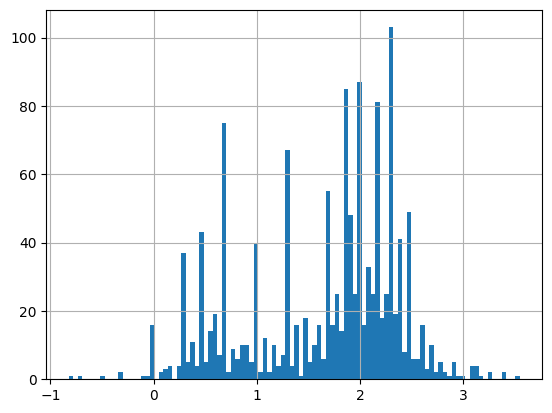

In [133]:
# already checked lat/lon above. No UTM or other coordinate systems that I saw.
# All thats left to do here is check for bi-modal distribution of MW/kW capacity.
# Eye test says there is no obvious bimodality separated by 3 orders of magnitude
acp.loc[row_subset, 'MW_Total_Capacity'].replace(0, np.nan).transform(np.log10).hist(bins=100)

### Formatting

In [137]:
# Set membership checks already covered status, phase type, owner type.
# State and county variation should mostly be handled by the geocoder.
# Variation in owner or developer names would be nice to clean up, but it's not a priority.
# ISO/RTO names definitely need to be standardized though.
acp.loc[:, 'ISORTOs'].str.strip().value_counts(dropna=False)

NaN                                                3256
MISO                                               1305
PJM                                                1186
CAISO                                              1075
ISO-NE                                              907
ERCOT                                               492
NYISO                                               414
Southwest Power Pool                                258
SPP                                                 107
ISO New England                                      26
Southwest Power Pool | MISO                          12
PJM | MISO                                           12
WECC-RMRG                                             5
PJM Interconnection                                   4
NYISO | ISO-NE                                        3
NYISO | PJM                                           3
Southwest Power Pool | ERCOT                          2
Southwest Power Pool | PJM                      

### Null Representation

In [139]:
# already checked this in the "Completeness" section, but here it is again:
acp[col_subset].select_dtypes("object").apply(
    lambda s: s.str.strip()
    .map({"": "empty string", np.nan: "null"})
    .fillna("non null value"),
    axis=1,
).agg(lambda s: s.value_counts(dropna=False, sort=False))

,Status,ProjectName,PhaseName,PhaseType,States,Counties,ISORTOs,Developers,Owners,OwnerTypes
empty string,NaN,NaN,NaN,NaN,NaN,49,NaN,NaN,NaN,NaN
non null value,9067.0,9069.0,9069.0,9069.0,9069.0,9006,5813.0,4684.0,8829.0,8831.0
null,2.0,NaN,NaN,NaN,NaN,14,3256.0,4385.0,240.0,238.0


In [146]:
# check numerics for "999" or other sentinel values
def nines_fraction(s: pd.Series):
    only_numbers = s.str.replace(r'[^0-9]', '', regex=True)
    nine_frac = only_numbers.str.count('9') / only_numbers.str.len()
    return nine_frac
nines_fraction(pd.Series(['999', '123', '99.999', '9.911']))

0    1.0
1    0.0
2    1.0
3    0.5
dtype: float64

In [147]:
acp.loc[:, col_subset].select_dtypes("number").astype('string').agg(nines_fraction).eq(1).agg(['sum', 'mean'])

,EIAPlantCode,MW_Total_Capacity,AvgLatitude,AvgLongitude
sum,0.0,59.000000,0.0,0.0
mean,0.0,0.006506,0.0,0.0


In [151]:
# I don't think 9.9 is a sentinel value. It is within the range of normal values.
is_nines = nines_fraction(acp.loc[:, 'MW_Total_Capacity'].astype('string')).eq(1)
acp.loc[is_nines, 'MW_Total_Capacity'].value_counts(dropna=False)

9.9    59
Name: MW_Total_Capacity, dtype: int64

<AxesSubplot: >

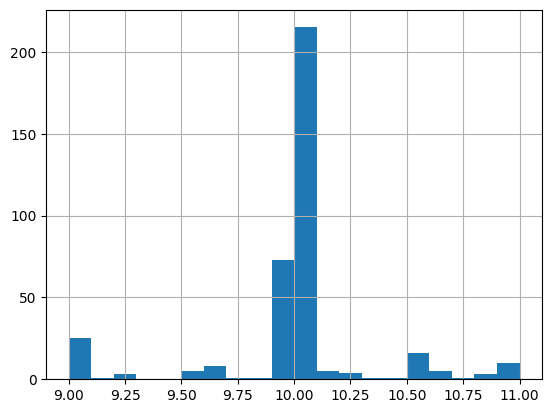

In [153]:
# but I'll check the histogram just in case
# [update: it does have a secondary peak at 9.9 (primary at 10.0), but I think 10.0 may be a regulatory threshold so I still think 9.9 is a normal value]
acp['MW_Total_Capacity'].hist(bins=20, range=(9,11))

## Consistency

A full scope of consistency checks would mean comparing vs ISO queue data and 860m data. But DBCP has already compared aggregates between those sources. I'll combine this with the accuracy check vs 860m below.

## Accuracy

Compare overlap vs EIA-860m. Non-overlapping data can only be spot checked vs public announcements.

In [ ]:
from dbcp.helpers import get_sql_engine
engine = get_sql_engine()
eia = pd.read_sql_table('projects_current_860m', engine, schema='data_mart')

/app/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/app/.local/lib/python3.10/site-packages/pudl/analysis/spatial.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/

In [ ]:
acp.groupby('EIAPlantCode')['MW_Total_Capacity'].agg(['sum', 'count', 'mean']).sort_values('count', ascending=False).head(10)

,sum,count,mean
EIAPlantCode,,,
50712.0,0.000,8,0.0000
6304.0,4.715,5,0.9430
57693.0,7.800,5,1.5600
56763.0,703.540,4,175.8850
64213.0,17.500,4,4.3750
56941.0,210.000,4,52.5000
64664.0,18.600,4,4.6500
66357.0,260.000,4,65.0000
56501.0,299.830,4,74.9575


In [161]:
acp.loc[row_subset,:].groupby('EIAPlantCode')['MW_Total_Capacity'].agg(['sum', 'count', 'mean']).sort_values('count', ascending=False).head(10)

,sum,count,mean
EIAPlantCode,,,
66494.0,620.0,4,155.000000
65445.0,323.0,3,107.666667
63798.0,600.0,2,300.000000
65891.0,238.4,2,119.200000
63933.0,250.0,2,125.000000
65821.0,405.0,2,202.500000
65823.0,116.0,2,58.000000
65849.0,240.0,2,120.000000
66637.0,450.0,2,225.000000


<AxesSubplot: >

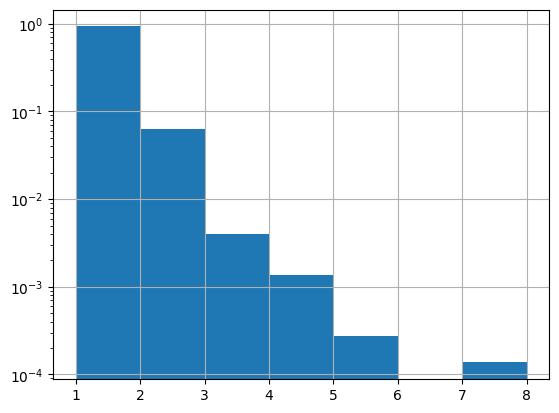

In [160]:
# 5-6% of EIA IDs have multiple entries
acp.groupby('EIAPlantCode')['MW_Total_Capacity'].count().hist(bins=7, log=True, density=True)

<AxesSubplot: >

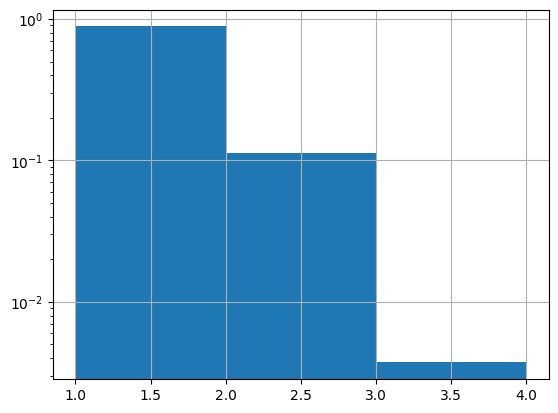

In [159]:
# ~10% of EIA IDs have multiple entries
acp.loc[row_subset,:].groupby('EIAPlantCode')['MW_Total_Capacity'].count().hist(bins=3, log=True, density=True)

In [ ]:
acp.query("EIAPlantCode == 6304")[col_subset]

,Status,EIAPlantCode,ProjectName,PhaseName,PhaseType,MW_Total_Capacity,States,Counties,ISORTOs,Developers,Owners,OwnerTypes,AvgLatitude,AvgLongitude
4429,Online,6304.0,Kotzebue Hybrid,Kotzebue Solar Plant,Solar,0.800,AK,Northwest Arctic Borough,NaN,NaN,Kotzebue Electric Association,Utility: Cooperative,66.893610,-162.596390
4430,Online,6304.0,Kotzebue Hybrid,Kotzebue Storage,Storage,1.200,AK,Northwest Arctic Borough,NaN,NaN,Kotzebue Electric Association,Utility: Cooperative,66.837778,-162.556900
4431,Online,6304.0,Kotzebue Hybrid,Kotzebue Wind Project,Wind,2.215,AK,Northwest Arctic Borough,NaN,Kotzebue Electric Association,Kotzebue Electric Association,Utility: Cooperative,66.835796,-162.558659
4432,Online,6304.0,Kotzebue Hybrid,Kotzebue Wind Project Phase I,Wind,0.150,AK,Northwest Arctic Borough,NaN,Kotzebue Electric Association,Kotzebue Electric Association,Utility: Cooperative,66.839300,-162.563512
4433,Online,6304.0,Kotzebue Hybrid,Kotzebue Wind Project Phases II & III,Wind,0.350,AK,Northwest Arctic Borough,NaN,Kotzebue Electric Association,Kotzebue Electric Association,Utility: Cooperative,66.839106,-162.555133


In [162]:
# these different phases look like they can be safely aggregated
acp.query("EIAPlantCode == 66494")[col_subset]

,Status,EIAPlantCode,ProjectName,PhaseName,PhaseType,MW_Total_Capacity,States,Counties,ISORTOs,Developers,Owners,OwnerTypes,AvgLatitude,AvgLongitude
5670,Under Construction,66494.0,Nova Battery Storage Project,Nova I,Storage,230.0,CA,Riverside County,CAISO,Calpine Corporation,Calpine Corporation,IPP,33.739005,-117.1698
5671,Under Construction,66494.0,Nova Battery Storage Project,Nova II,Storage,230.0,CA,Riverside County,CAISO,Calpine Corporation,Calpine Corporation,IPP,33.739005,-117.1698
5672,Under Construction,66494.0,Nova Battery Storage Project,Nova III,Storage,50.0,CA,Riverside County,CAISO,Calpine Corporation,Calpine Corporation,IPP,33.739005,-117.1698
5673,Under Construction,66494.0,Nova Battery Storage Project,Nova IV,Storage,110.0,CA,Riverside County,CAISO,Calpine Corporation,Calpine Corporation,IPP,33.739005,-117.1698


In [164]:
# some EIA plants have an obscene number of generators
eia.groupby('plant_id_eia')['capacity_mw'].agg(['sum', 'count', 'mean']).sort_values('count', ascending=False).head(10)

,sum,count,mean
plant_id_eia,,,
1751,41.800001,73,0.572603
56684,14.400001,48,0.300000
56687,14.400001,48,0.300000
56683,14.400001,48,0.300000
56681,14.400001,48,0.300000
59074,101.799999,45,2.262222
6304,22.400000,37,0.605405
56686,10.800000,36,0.300000
56692,10.800000,36,0.300000


In [163]:
# I'll aggregate to (ID, fuel type). First I need to standardize the fuel types.

In [ ]:
eia['fuel_type_code_pudl'].value_counts()

gas        8873
solar      7014
oil        5655
hydro      4562
waste      2889
wind       1759
coal       1404
other      1351
nuclear     107
Name: fuel_type_code_pudl, dtype: int64

In [ ]:
acp['PhaseType'].value_counts()

Solar            6308
 Wind            1806
Storage           931
Offshore Wind      24
Name: PhaseType, dtype: int64

In [171]:
acp_loc['fuel_type_code_pudl'] = acp_loc['PhaseType'].str.strip().map(
    {
        'Solar': 'solar',
        'Wind': 'wind',
        'Storage': 'other',
        'Offshore Wind': 'wind',
    }
)

In [178]:
# exclude (most) retired plants (multi-status projects still come through)
acp_agg = (
    acp_loc.loc[
        acp_loc["EIAPlantCode"].notnull() & acp_loc["Status"].ne("Decommissioned"), :
    ]
    .groupby(["EIAPlantCode", "fuel_type_code_pudl"])
    .agg(
        {
            "MW_Total_Capacity": "sum",
            "AvgLatitude": "mean",
            "AvgLongitude": "mean",
            "States": "first",
            "Counties": "first",
            "ISORTOs": "first",
            "Developers": "first",
            "Owners": "first",
            "OwnerTypes": "first",
            "Status": "first",
            "ProjectName": "first",
            "PhaseName": "size",  # count number of phases
            "county_id_fips": "first",
            "geocoded_containing_county": "first",
        }
    )
)

In [190]:
# exlcude retired plants
eia_agg = eia.query('operational_status_category != "retired"').groupby(['plant_id_eia', 'fuel_type_code_pudl']).agg(
    {
        'plant_name_eia': 'first',
        'capacity_mw': 'sum',
        'operational_status_code': 'first',
        'operational_status_category': 'first',
        'utility_name_eia': 'first',
        'state': 'first',
        'county': 'first',
        'latitude': 'mean',
        'longitude': 'mean',
        'county_id_fips': 'first',        
    }
)

In [195]:
overlap = eia_agg.merge(acp_agg, left_on=['plant_id_eia', 'fuel_type_code_pudl'], right_on=['EIAPlantCode', 'fuel_type_code_pudl'], how='outer', indicator=True)

In [196]:
overlap['_merge'].value_counts(dropna=False)

both          7298
left_only     6997
right_only     290
Name: _merge, dtype: int64

In [197]:
overlap['capacity_diff'] = overlap['capacity_mw'] - overlap['MW_Total_Capacity']

<AxesSubplot: >

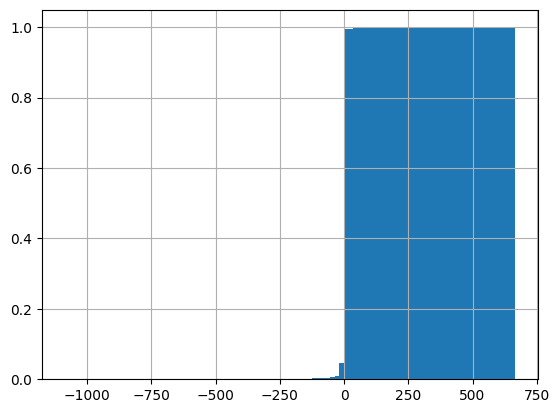

In [198]:
# less than 5% on either side have a capacity difference
overlap['capacity_diff'].hist(bins=100, density=True, cumulative=True)

<AxesSubplot: >

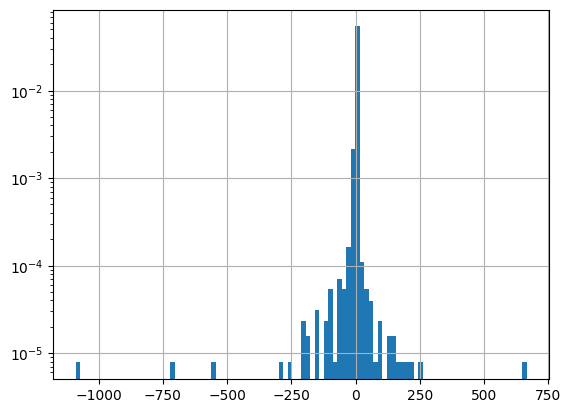

In [200]:
overlap['capacity_diff'].hist(bins=100, density=True, log=True)

In [203]:
# only look at records that overlap when calculating the frequency
overlap.loc[overlap['_merge'].eq('both'), 'capacity_diff'].abs().gt(0.1).agg(['sum', 'mean'])

sum     964.000000
mean      0.132091
Name: capacity_diff, dtype: float64

In [204]:
overlap.loc[overlap['_merge'].eq('both'), 'capacity_diff'].describe()

count    7298.000000
mean       -0.528045
std        21.680167
min     -1088.600098
25%         0.000000
50%         0.000000
75%         0.000000
max       666.040000
Name: capacity_diff, dtype: float64

In [223]:
# what do the extreme values look like?
overlap.loc[overlap['capacity_diff'].abs().gt(250), :]

,plant_name_eia,capacity_mw,operational_status_code,operational_status_category,utility_name_eia,state,county,latitude,longitude,county_id_fips_x,MW_Total_Capacity,AvgLatitude,AvgLongitude,States,Counties,ISORTOs,Developers,Owners,OwnerTypes,Status,ProjectName,PhaseName,county_id_fips_y,geocoded_containing_county,_merge,capacity_diff
fuel_type_code_pudl,,,,,,,,,,,,,,,,,,,,,,,,,,
wind,Chokecherry and Sierra Madre Wind,3000.000000,4.0,proposed,Power Company of Wyoming LLC,WY,Carbon,41.683056,-107.199997,56007,3550.00,41.528197,-107.235654,WY,Carbon County,None,Power Company of Wyoming LLC,Power Company of Wyoming LLC,IPP,Under Construction,Chokecherry and Sierra Madre Wind Energy Project,2.0,56007,Carbon County,both,-550.000000
wind,Two Rivers Wind Facility,6.100000,2.0,proposed,Two Rivers Wind LLC,WY,Carbon,41.975079,-106.180496,56007,305.00,41.975080,-106.180500,WY,Carbon County,None,BluEarth Renewables US LLC | Clearway Energy G...,BluEarth Renewables US LLC | Clearway Energy G...,IPP,Advanced Development,Two Rivers,1.0,56007,Carbon County,both,-298.900000
wind,Red Cloud Wind LLC,350.000000,7.0,existing,Pattern Operators LP,NM,Lincoln,34.274063,-105.422897,35027,1055.60,34.466839,-105.366272,NM,Guadalupe County | Lincoln County | Torrance ...,None,"Pattern Energy Group Services, LP","Pattern Energy Group Services, LP",IPP,Online,Western Spirit Wind,1.0,35019,Guadalupe County,both,-705.600000
wind,Great Prairie Wind,1027.000000,7.0,existing,Great Prairie Wind LLC,TX,Hansford,36.307499,-101.532204,48195,360.96,36.313795,-101.499076,TX,Hansford County,SPP,NextEra Energy Resources,NextEra Energy Resources,IPP,Online,Great Prairie Wind (Firewheel Wind),1.0,48195,Hansford County,both,666.040000
wind,Ponderosa Wind II,358.000000,1.0,proposed,"Ponderosa Wind II, LLC",OK,Beaver,36.589451,-100.803703,40007,100.00,36.589452,-100.803700,OK,Beaver County,None,NextEra Energy Resources,NextEra Energy Resources,IPP,Advanced Development,Ponderosa,1.0,40007,Beaver County,both,258.000000
wind,SunZia Wind South,2426.399902,3.0,proposed,Pattern Operators LP,NM,Torrance,34.139000,-105.535500,35057,3515.00,NaN,NaN,NM,Lincoln County,None,PATTERN ENERGY GROUP,PATTERN ENERGY GROUP,IPP,Under Construction,SunZia,1.0,35027,Lincoln County,both,-1088.600098


In [207]:
# how are the status categories distributed in the different overlap regions?
overlap.groupby(['_merge', 'operational_status_category', 'Status'], dropna=False, observed=True).size().sort_index()

_merge      operational_status_category  Status                 
left_only   existing                     NaN                        6356
            proposed                     NaN                         641
right_only  NaN                          Advanced Development         42
                                         Online                      152
                                         Online | Decommissioned       4
                                         Under Construction           92
both        existing                     Advanced Development          2
                                         Online                     6548
                                         Online | Decommissioned      29
                                         Under Construction            6
            proposed                     Advanced Development        138
                                         Online                      271
                                         Under Construction

In [212]:
county_eq = overlap.loc[overlap['_merge'].eq('both'), 'county_id_fips_x'].eq(overlap.loc[overlap['_merge'].eq('both'), 'county_id_fips_y'])
county_eq.agg(['sum', 'mean'])

sum     6885.000000
mean       0.943409
dtype: float64

In [221]:
county_ne = overlap.loc[overlap['_merge'].eq('both'),:].loc[~county_eq, :]
county_ne.shape[0]

413

In [219]:
# a decent chunk are missing FIPS codes due to PUDL's weak county matching
county_ne['county_id_fips_x'].value_counts(dropna=False).head(10)

None     56
24510    11
27117     5
06029     5
48371     4
48353     4
41049     4
36057     4
37085     3
27131     3
Name: county_id_fips_x, dtype: int64

In [220]:
county_ne['county_id_fips_y'].value_counts(dropna=False).head(10)

24005    13
None     12
36089    11
12111     8
12086     6
18141     5
06037     5
27101     5
40015     4
06029     4
Name: county_id_fips_y, dtype: int64

In [224]:
county_ne.loc[county_ne[['county_id_fips_x', 'county_id_fips_y']].notnull().all(axis=1), :].sample(10, random_state=2)

,plant_name_eia,capacity_mw,operational_status_code,operational_status_category,utility_name_eia,state,county,latitude,longitude,county_id_fips_x,MW_Total_Capacity,AvgLatitude,AvgLongitude,States,Counties,ISORTOs,Developers,Owners,OwnerTypes,Status,ProjectName,PhaseName,county_id_fips_y,geocoded_containing_county,_merge,capacity_diff
fuel_type_code_pudl,,,,,,,,,,,,,,,,,,,,,,,,,,
wind,Clearwater Wind I,365.500000,7.0,existing,Clearwater Energy Resources LLC,MT,Rosebud,46.817711,-106.378899,30087,365.52,46.830771,-106.406172,MT,Garfield County | Rosebud County,MISO,NextEra Energy Resources,NextEra Energy Resources,IPP,Online,Clearwater Energy Resources,1.0,30033,Garfield County,both,-0.020000
solar,"Copperhead Solar, LLC",150.000000,5.0,proposed,National Grid Renewables,TX,McLennan,31.450001,-96.860001,48309,150.00,31.458910,-96.861720,TX,Falls County,ERCOT,National Grid Renewables,National Grid Renewables,IPP,Online,Copperhead Solar + Storage Project (Coral),1.0,48145,Falls County,both,0.000000
wind,Limestone Wind Project,299.200012,7.0,existing,"Limestone Wind Project, LLC",TX,Navarro,31.853460,-96.624458,48349,299.20,31.824523,-96.670365,TX,Limestone County | Navarro County,ERCOT,ENGIE North America,ENGIE North America,IPP,Online,Limestone Wind,1.0,48293,Limestone County,both,0.000012
wind,Arbuckle Mountain Wind Farm LLC,100.000000,7.0,existing,Arbuckle Mountain Wind Farm LLC,OK,Murray,34.386944,-97.136940,40099,100.00,34.389004,-97.174458,OK,Carter County | Murray County,Southwest Power Pool,EDP Renewables North America LLC,EDP Renewables North America LLC | Axium Infra...,IPP,Online,Arbuckle Mountain,1.0,40019,Carter County,both,0.000000
solar,Hollins Ferry CSG,1.500000,7.0,existing,"ICFTS MD Solar, LLC",MD,Baltimore City,39.225754,-76.688080,24510,1.50,39.225752,-76.688080,MD,Baltimore County,PJM,Summit Ridge Energy LLC,Summit Ridge Energy LLC,IPP,Online,Hollins Ferry Road Solar Project,1.0,24005,Baltimore County,both,0.000000
solar,Bright Hill Solar LLC(CSG),5.000000,7.0,existing,Nautilus Solar Solutions,NY,Livingston,42.467232,-77.703781,36051,5.00,42.467230,-77.703780,NY,Steuben County,NYISO,None,None,None,Online,Bright Hill Solar,1.0,36101,Steuben County,both,0.000000
solar,Vidalia Water Treatment Plant,1.000000,7.0,existing,Terraform Arcadia,GA,Lowndes,31.050322,-83.394661,13185,1.00,31.050322,-83.394660,GA,Cook County,None,None,Terraform Power,IPP: YieldCo,Online,Vidalia Water Treatment Plant,1.0,13075,Cook County,both,0.000000
wind,Wolverine Creek,64.500000,7.0,existing,Invenergy Services LLC,ID,Bonneville,43.419498,-111.829399,16019,64.50,43.384137,-111.843264,ID,Bingham County | Bonneville County,None,Invenergy,Invenergy,IPP,Online,Wolverine Creek,1.0,16011,Bingham County,both,0.000000
solar,Aratina Solar Center 1 Hybrid,200.000000,1.0,proposed,91MC 8me LLC,CA,San Bernardino,34.987953,-117.571602,06071,200.00,35.324870,-118.727980,CA,Kern County,CAISO,Avantus,Avantus,IPP,Advanced Development,Aratina Solar Center,1.0,06029,Kern County,both,0.000000


# Sanity Check

In [6]:
from dbcp.transform.acp_projects import transform

/app/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/app/.local/lib/python3.10/site-packages/pudl/analysis/spatial.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/

In [20]:
trans = transform(acp)

2024-07-29 22:30:48 [    INFO] catalystcoop.pudl.helpers:203 Assigned state FIPS codes for 100.00% of records.
2024-07-29 22:30:50 [    INFO] catalystcoop.pudl.helpers:219 Assigned county FIPS codes for 99.20% of records.
2024-07-29 22:30:50 [    INFO] catalystcoop.pudl.helpers:203 Assigned state FIPS codes for 100.00% of records.
2024-07-29 22:30:50 [    INFO] catalystcoop.pudl.helpers:219 Assigned county FIPS codes for 21.13% of records.
2024-07-29 22:30:50 [    INFO] catalystcoop.pudl.helpers:203 Assigned state FIPS codes for 100.00% of records.
2024-07-29 22:30:50 [    INFO] catalystcoop.pudl.helpers:219 Assigned county FIPS codes for 0.00% of records.
2024-07-29 22:30:50 [    INFO] catalystcoop.pudl.helpers:203 Assigned state FIPS codes for 100.00% of records.
2024-07-29 22:30:50 [    INFO] catalystcoop.pudl.helpers:219 Assigned county FIPS codes for 0.00% of records.


In [21]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9069 entries, 0 to 9068
Data columns (total 72 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   raw_mw_total_capacity               9069 non-null   float64
 1   raw_units_total                     9069 non-null   int64  
 2   raw_mw_online_capacity              7579 non-null   float64
 3   raw_units_online                    7579 non-null   float64
 4   raw_mw_under_construction_capacity  546 non-null    float64
 5   raw_units_under_construction        546 non-null    float64
 6   raw_mw_adv_development_capacity     818 non-null    float64
 7   raw_units_adv_development           818 non-null    float64
 8   raw_mw_decommissioned_capacity      164 non-null    float64
 9   raw_units_decommissioned            164 non-null    float64
 10  raw_years_online                    7704 non-null   object 
 11  raw_quarters_online                 7704 no